# Exploratory Analysis of Book-Crossing Dataset

[Book-Crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) contains data about explicit and implicit book ratings. It consists of 3 tables: ratings, books and users. It provides detailed information about both books (title, author, year of publication) and users (location, age).

There are 433,642 ratings of 186k books given by 78k users. Average number of ratings per book is 5.57 and average number of ratings given by one user is 2.33.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle

import functions as f

In [2]:
df_ratings = pd.read_csv('data/ratings_explicit.csv')
df_books = pd.read_csv('data/books.csv')
df_users = pd.read_csv('data/users.csv')
df_ratings_implicit = pd.read_csv('data/ratings_implicit.csv')

In [3]:
dist_user = f.df_dist(df_ratings, 'user_id')
dist_book = f.df_dist(df_ratings, 'isbn')

In [4]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(df_ratings),
                                                                           len(df_ratings['isbn'].unique()),
                                                                           len(df_ratings['user_id'].unique())))

Number of ratings: 433642
Number of books: 185946
Number of users: 77792


In [5]:
print('Average number of ratings per book: %.2f\nAverage number of ratings per user: %.2f' % (dist_user['count'].mean(),
                                                                                              dist_book['count'].mean()))

Average number of ratings per book: 5.57
Average number of ratings per user: 2.33


## Distribution of number of ratings per book and user

Distributions of number of ratings per book and user are strongly right-skewed, showing that majority of books / users have / gave few ratings. At the same time there are some outliers with values very distant from mean that are responsible for a long tail of the distribution.

Both distributions have a median = 1 and mode = 1 which confirms that the dataset is full of records with only one rating.

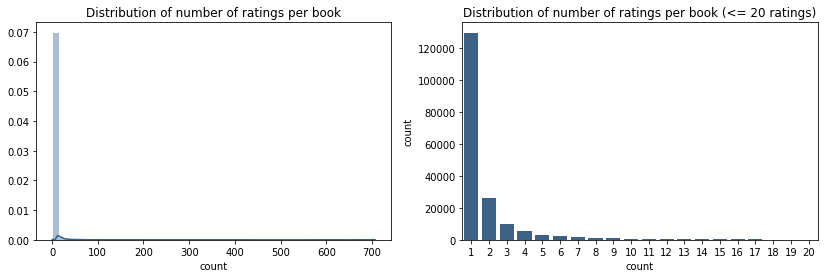

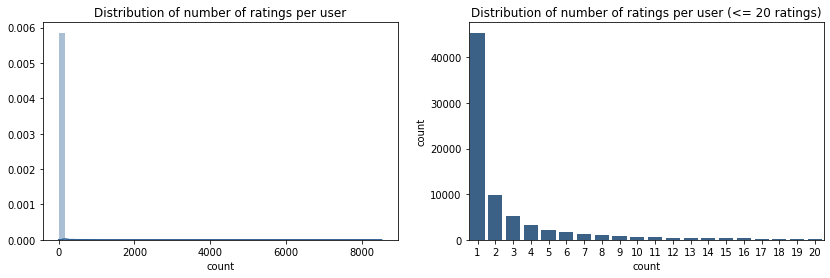

In [6]:
f.draw_distribution(dist_book, 'book')
f.draw_distribution(dist_user, 'user')

## Distribution of book ratings

The majority of ratings is positive - 95% of all ratings is between 5 and 10. Most often users tend to rate books for 8. Second the most frequent score is 10.

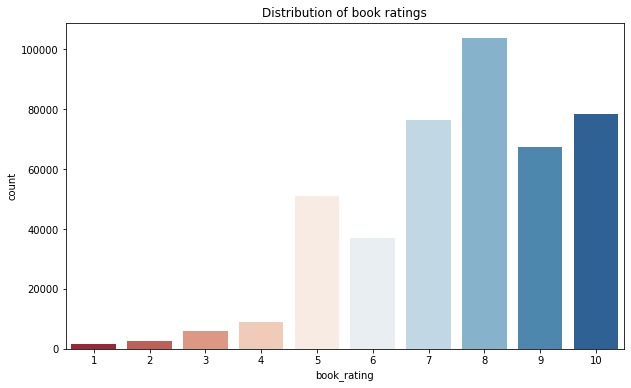

In [7]:
palette = sns.color_palette("RdBu", 10)

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='book_rating', data=df_ratings, palette=palette)
ax.set_title('Distribution of book ratings')

plt.show()

In [8]:
df_ratings_b = df_ratings.merge(df_books, on='isbn', how='left')

In [9]:
df_books_year = f.books_groupby(df_ratings_b, 'year_of_publication', 'year')
df_books_year = df_books_year[df_books_year['year'].between(1950,2004)]
df_books_year['year'] = df_books_year['year'].astype(int)

## Book ratings by year of publication

The majority of books in the dataset was published starting from 1950 (the older books vere filtered out in visualization). Since the collection of data took place in 2004, this is the last year of publication (there were several records with "newer" books but they were skipped).

The visualization shows that the books with the biggest number of ratings are the most recent ones (reaching two years back). Books from last two years are already popular but they still need time to gather more ratings.

There is no visible relationship between year of publication and average rating. The average book ratings for further years differ more (it's due to limited number of ratings - the more ratings, the more average rating is "smoothed").

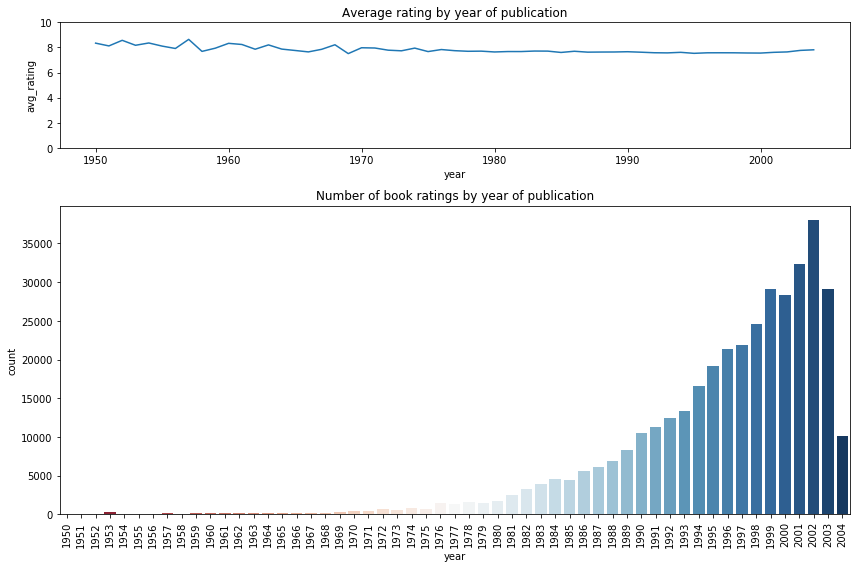

In [10]:
palette = sns.color_palette("RdBu", len(df_books_year['year'].unique()))

gridsize = (3, 1)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=2)

sns.lineplot(x='year', y='avg_rating', data=df_books_year, palette=palette, ax=ax1)
ax1.set_title('Average rating by year of publication')
ax1.set_ylim([0,10])

sns.barplot(x='year', y='count', data=df_books_year, palette=palette, ax=ax2)
ax2.set_title('Number of book ratings by year of publication')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
df_books_title = f.books_groupby(df_ratings_b, 'book_title', 'title')
df_books_title['title_short'] = df_books_title['title'].apply(f.short_title)

## Top books and authors

Books with the highest number of ratings are also positively rated - all except one have the average rating between 7-10. Among books with the highest ratings (and at least 50 votes) there are both top popular books and those with moderate number of ratings. Among top-rated books there are highly recognizable works of J.K. Rowling and J.R.R. Tolkien.

Similarly to books, the most popular authors are also the ones with very good scores. The author with the highers number of votes is Stephen King. Both he and Nora Roberts own their popularity to the big number of works - they are in the top 10 of authors with the highest number of books (in the dataset).

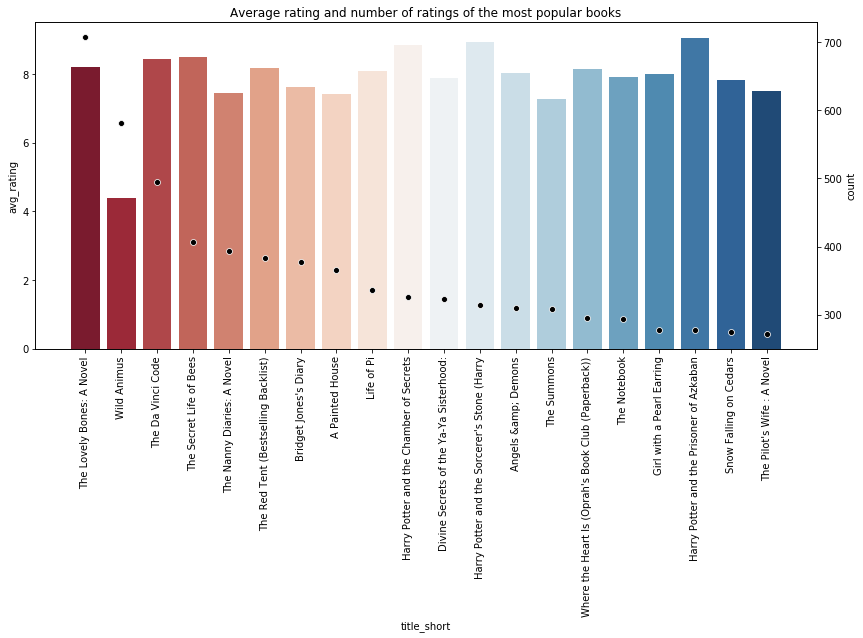

In [12]:
titles_top_popular = df_books_title.sort_values('count', ascending=False).head(20)
f.draw_top_chart(titles_top_popular, 'title_short', ['avg_rating', 'count'], 'Average rating and number of ratings of the most popular books')

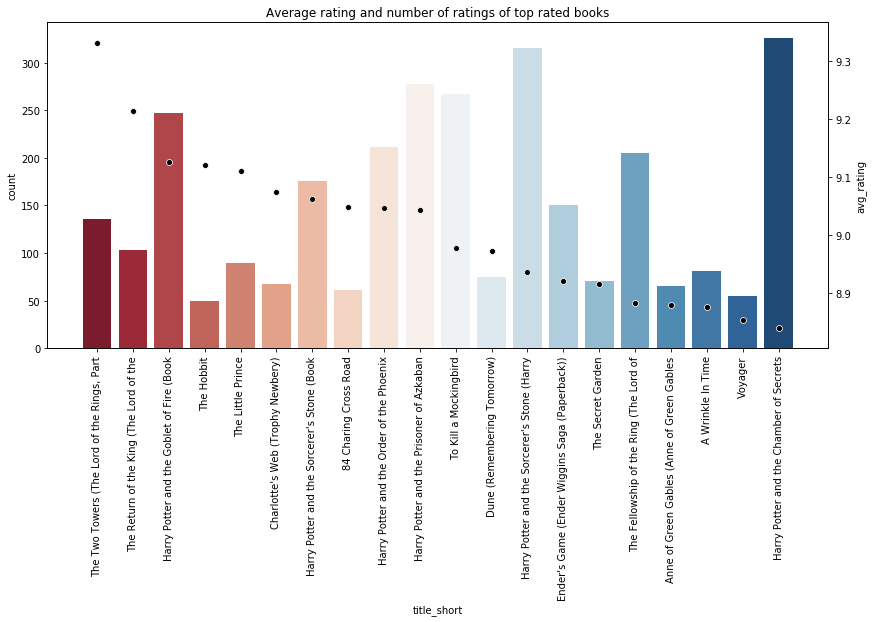

In [13]:
titles_top_rated = df_books_title.sort_values('avg_rating', ascending=False)
titles_top_rated = titles_top_rated[titles_top_rated['count']>=50].head(20)

f.draw_top_chart(titles_top_rated, 'title_short', ['count', 'avg_rating'], 'Average rating and number of ratings of top rated books')

In [14]:
df_books_author = f.books_groupby(df_ratings_b, 'book_author', 'author')

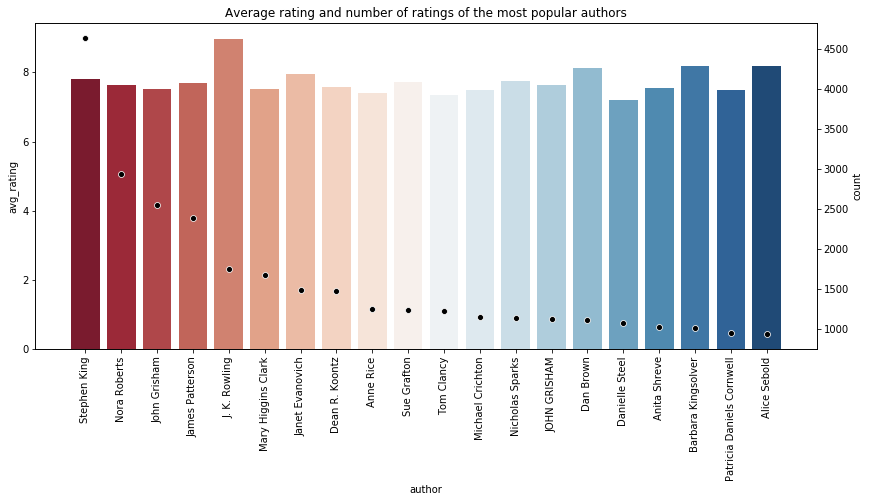

In [15]:
authors_top_popular = df_books_author.sort_values('count', ascending=False).head(20)
f.draw_top_chart(authors_top_popular, 'author', ['avg_rating', 'count'], 'Average rating and number of ratings of the most popular authors')

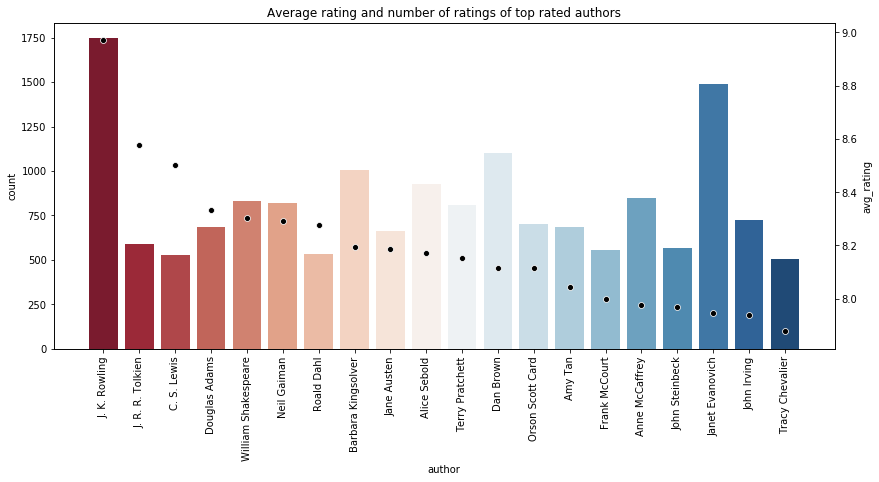

In [16]:
authors_top_rated = df_books_author.sort_values('avg_rating', ascending=False)
authors_top_rated = authors_top_rated[authors_top_rated['count']>=500].head(20)

f.draw_top_chart(authors_top_rated, 'author', ['count', 'avg_rating'], 'Average rating and number of ratings of top rated authors')

## Comparison of explicit and implicit ratings

Book-Crossing dataset contains both explicit (expressed on a scale from 1-10) and implicit (user interacted with the book) ratings. The analysis of relationship between those two metrics reveals that:
* books that have many implicit ratings are also frequently rated on 1-10 scale (Pearson's correlation is 0.87 which shows the strong relationship)
* there is no relationship between number of implicit ratings and average score from explicit rating.

Implicit ratings seem to be a good indicator of book's popularity but they don't bring information about the liking of the reading.

In [17]:
dist_book_impl = f.df_dist(df_ratings_implicit, 'isbn')
dist_book_expl = df_ratings.groupby('isbn').agg({'book_rating': ['count','mean']}).reset_index()
dist_book_expl.columns = ['isbn', 'count', 'avg_rating']

In [18]:
ratings_comparison = dist_book_expl.merge(dist_book_impl, on='isbn', how='left', suffixes=['_expl', '_impl'])
ratings_comparison = ratings_comparison[(ratings_comparison['count_expl']>5)&(ratings_comparison['count_impl']>5)]

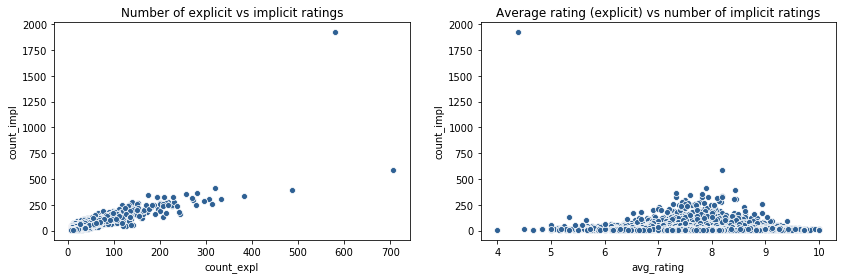

Correlation between number of explicit and implicit ratings: 0.87


In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.scatterplot(x='count_expl', y='count_impl', data=ratings_comparison, color='#2f6194', ax=ax1)
ax1.set_title('Number of explicit vs implicit ratings')

sns.scatterplot(x='avg_rating', y='count_impl', data=ratings_comparison, color='#2f6194', ax=ax2)
ax2.set_title('Average rating (explicit) vs number of implicit ratings')

plt.show()

print('Correlation between number of explicit and implicit ratings: %.2f' % ratings_comparison[['count_expl', 'count_impl']].corr().iloc[0][1])

## Distribution of age of Book-Crossing users

Book-Crossing dataset contains mostly users between 10-80 years old. The highest amount of users is aged between 20-30 years. The distribution of number of given ratings by age is very similar to the distribution of all users by age (although is less smooth).

In [20]:
df_ratings_u = df_ratings.merge(df_users, on='user_id', how='left')
df_ratings_u['age_round'] = df_ratings_u['age'].round(-1)

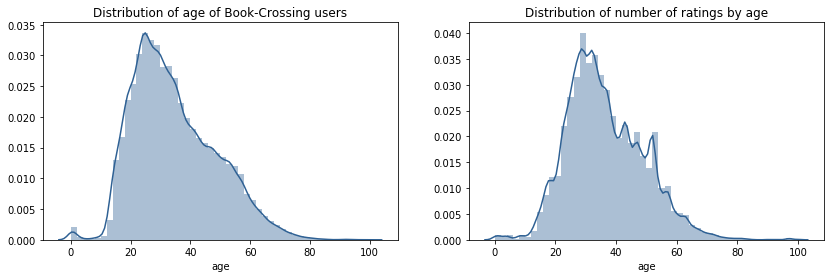

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_users[(df_users['age'].notna())&(df_users['age']<=100)]['age'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of age of Book-Crossing users')

sns.distplot(df_ratings_u[(df_ratings_u['age'].notna())&(df_ratings_u['age']<=100)]['age'], color='#2f6194', ax=ax2)
ax2.set_title('Distribution of number of ratings by age')

plt.show()

## Distribution of book ratings by country

The majority of book ratings comes from USA (65%), Canada (10%) and United Kingdom (5%) - so ~80% of all ratings are provided by users from English-speaking countries. Other countries with noticeable share in ratings are from Western Europe.

In [22]:
df_users_country = df_ratings_u['country'].value_counts(normalize=True).reset_index()
df_users_country.columns = ['country', 'share']
df_users_country.loc[df_users_country['share']<0.01] = 'Other', df_users_country[df_users_country['share']<0.01]['share'].sum()
df_users_country.drop_duplicates(inplace=True)

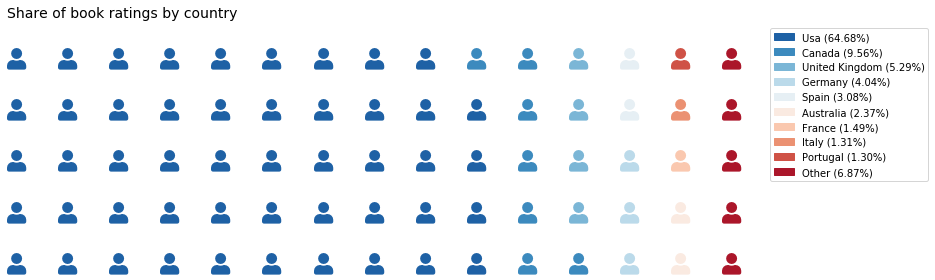

In [26]:
waffle_data = df_users_country.set_index('country').T.to_dict('records')[0]

fig = plt.figure(
        FigureClass = Waffle,
        figsize = (18,4),
        rows = 5,
        columns = 15,
        values = waffle_data,
        labels = ["%s (%.2f%%)" % (k, v*100) for k, v in waffle_data.items()],
        legend = {
            'loc': 'upper left',
            'bbox_to_anchor': (1, 1)
        },
        colors = sns.color_palette("RdBu_r", len(waffle_data)).as_hex(),
        icons = 'user',
        font_size = 22,
        title = {
            'label': 'Share of book ratings by country',
            'loc': 'left',
            'fontdict': {
                'fontsize': 14
            }
        }
)

plt.show()

* Correlation explicit and implicit ratings
* Age of user and votes

In [9]:
user_threshold = 3
book_threshold = 0.05

user_list = dist_user[dist_user['count']>=user_threshold]['user_id'].unique()
df_top = df[df['user_id'].isin(user_list)]
print('number of users with more than %d ratings: %d' % (user_threshold, len(user_list)))
print('number of ratings', len(df_top))

dist_book2 = df_dist(df_top, 'isbn', norm=True)
book_list = dist_book2.head(int(book_threshold * len(dist_book2)))['isbn'].unique()
df_top = df_top[df_top['isbn'].isin(book_list)]

print('\nnumber of top %d%% most popular books: %d' % (book_threshold*100, len(book_list)))
print('number of ratings', len(df_top))

number of users with more than 3 ratings: 22567
number of ratings 368563

number of top 5% most popular books: 8383
number of ratings 138181


In [23]:
df_top.to_csv('data/ratings_top.csv', encoding='utf-8', index=False)